# Extração de grafos de conhecimento de bulas de medicamentos de arquivos PDF extraídos do bulário eletrônico da ANVISA


**Materiais úteis**
- [Preparing PDFs for RAGs: um comparativo entre bibliotecas](https://towardsdatascience.com/preparing-pdfs-for-rags-b1579fc697f1/)
- [Build a knowledge graph from documents using Docling](https://alain-airom.medium.com/build-a-knowledge-graph-from-documents-using-docling-8bc05e1389f7)
- [Using PyMuPDF4LLM: A Practical Guide for PDF Extraction in LLM & RAG Environments](https://medium.com/@danushidk507/using-pymupdf4llm-a-practical-guide-for-pdf-extraction-in-llm-rag-environments-63649915abbf)
- [How To Extract Structured Knowledge From Unstructured PDFs?](https://medium.com/@dreamai/how-to-extract-structured-knowledge-from-unstructured-pdfs-b5b1b101041e)
- [GraphRAG Python Package: Accelerating GenAI With Knowledge Graphs](https://neo4j.com/blog/news/graphrag-python-package/)
- [How to parse PDF docs for RAG](https://cookbook.openai.com/examples/parse_pdf_docs_for_rag)
- [Build Knowledge Graph RAG with LlamaIndex from PDF Document](https://www.linkedin.com/pulse/build-knowledge-graph-rag-llamaindex-from-pdf-documents-peng-wang-areoc/)
- [Knowledge Graph from Unstructured Text](https://www.superteams.ai/blog/knowledge-graph-from-unstructured-text)

In [4]:
!python3 -m spacy download pt_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 21.2 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash dd4327e08668463153bee7a9220b4c04
INFO:docling.utils.accelerator_utils:Accelerator device: 'cpu'
INFO:docling.utils.accelerator_utils:Accelerator device: 'cpu'
INFO:docling.utils.accelerator_utils:Accelerator device: 'cpu'
INFO:docling.pipeline.base_pipeline:Processing document bula_1748876242121.pdf
INFO:docling.document_converter:Finished converting document bula_1748876242121.pdf in 12.64 sec.
INFO:__main__:Document converted in 12.64 seconds.


## paracetamol

Aché Laboratórios Farmacêuticos S.A. C omprimidos revestidos 750 mg

A

A

S

## BULA PARA PACIENTE

Bula de acordo com a Resolução-RDC nº 47/2009

## I.IDENTIFICAÇÃO DO MEDICAMENTO

## paracetamol

Medicamento Genérico Lei nº 9.787, de 1999

## APRESENTAÇÕES

Comprimidos revestidos de 750 mg: embalagens com 20 ou 200 comprimidos.

## USO ORAL

USO ADULTO E PEDIÁTRICO ACIMA DE 12 ANOS

## COMPOSIÇÃO

Cada comprimido revestido contém:

paracetamol..........................................................................................................................................750 mg

Excipientes:  povidona,  amidoglicolato  de  sódio,  amido,  ácido  esteárico,  álcool  polivinílico,  macrogol, talco e dióxido de titânio.

## II. INFORMAÇÕES AO PACIENTE

## 1. PARA QUE ESTE MEDICAMENTO É INDICADO?

Este  medicamento  é  indicado  para  a  redução  da  febre  e  para  o  alívio  temporário  de  dores  leves  a moderadas, tais como dores associadas a resfriados comun

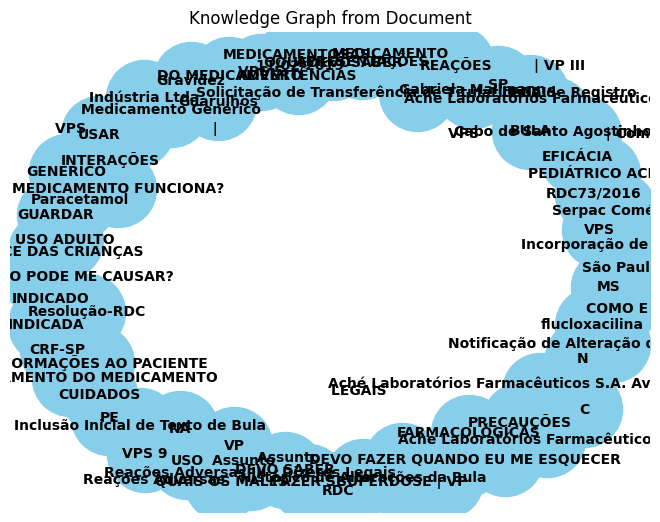


Nodes: [('BULA', {'label': 'ORG'}), ('Resolução-RDC', {'label': 'ORG'}), ('DO MEDICAMENTO', {'label': 'MISC'}), ('Medicamento Genérico', {'label': 'MISC'}), ('APRESENTAÇÕES', {'label': 'MISC'}), ('USO', {'label': 'ORG'}), ('USO ADULTO', {'label': 'ORG'}), ('PEDIÁTRICO ACIMA', {'label': 'ORG'}), ('INFORMAÇÕES AO PACIENTE', {'label': 'ORG'}), ('MEDICAMENTO', {'label': 'MISC'}), ('INDICADO', {'label': 'MISC'}), ('MEDICAMENTO FUNCIONA?', {'label': 'MISC'}), ('Paracetamol', {'label': 'MISC'}), ('DEVO SABER', {'label': 'MISC'}), ('Gravidez', {'label': 'LOC'}), ('flucloxacilina', {'label': 'LOC'}), ('COMO E', {'label': 'ORG'}), ('GUARDAR', {'label': 'PER'}), ('C', {'label': 'MISC'}), ('ALCANCE DAS CRIANÇAS', {'label': 'ORG'}), ('DEVO FAZER QUANDO EU ME ESQUECER', {'label': 'LOC'}), ('USAR', {'label': 'ORG'}), ('QUAIS OS MALES', {'label': 'MISC'}), ('MEDICAMENTO PODE ME CAUSAR?', {'label': 'MISC'}), ('FAZER SE', {'label': 'MISC'}), ('INDICADA', {'label': 'MISC'}), ('LEGAIS', {'label': 'MISC'}

In [ ]:
import json
import logging
import time
from pathlib import Path

import spacy
import networkx as nx
import matplotlib.pyplot as plt

from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    AcceleratorOptions,
    PdfPipelineOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption

FILE_PATH = "/home/marilia/git/pos/tcc_ufg_akcit_nlp/data/raw/bula_1748876242121.pdf"
PROCESSED_FILE_PATH = "/home/marilia/git/pos/tcc_ufg_akcit_nlp/data/processed/"

# Load a spaCy language model
nlp = spacy.load("pt_core_news_md")

def extract_text_from_docling_document(docling_document):
    """Extracts text content from a Docling Document object."""
    text = docling_document.export_to_text()
    return text

def save_text_on_md_file(text: str, file_name: str, base_dir:str=PROCESSED_FILE_PATH):
    file_path = f"{base_dir}{file_name}.md"
    with open(file_path, "w") as f:
       f.write(text)

def build_knowledge_graph(text):
    doc = nlp(text)
    graph = nx.Graph()

    # Extract entities
    for ent in doc.ents:
        graph.add_node(ent.text, label=ent.label_)

    # Simple relationship extraction (can be improved)
    for sent in doc.sents:
        for i, token in enumerate(sent):
            if token.dep_ in ["nsubj", "dobj"]:
                subject = [w for w in token.head.lefts if w.dep_ == "nsubj"]
                object_ = [w for w in token.head.rights if w.dep_ == "dobj"]
                if subject and object_:
                    graph.add_edge(subject[0].text, object_[0].text, relation=token.head.lemma_)
                elif subject and token.head.lemma_ in ["be", "have"]:
                    right_children = [child for child in token.head.rights if child.dep_ in ["attr", "acomp"]]
                    if right_children:
                        graph.add_edge(subject[0].text, right_children[0].text, relation=token.head.lemma_)
    return graph

def visualize_knowledge_graph(graph):
    """Visualizes the knowledge graph."""
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(graph, 'relation')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Knowledge Graph from Document")
    plt.show()

def main():
    logging.basicConfig(level=logging.INFO)
    _log = logging.getLogger(__name__)  # Initialize the logger here
    #nlp = spacy.load("en_core_web_sm") # Load spacy # Removed from here
    #input_doc_path = Path("./input/2503.11576v1.pdf")
    input_doc_path = Path(FILE_PATH)

    ###########################################################################
    # Docling Parse with EasyOCR
    # ----------------------
    pipeline_options = PdfPipelineOptions()
    pipeline_options.do_ocr = True
    pipeline_options.do_table_structure = True
    pipeline_options.table_structure_options.do_cell_matching = True
    # pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
    # pipeline_options.generate_page_images = True
    # pipeline_options.generate_picture_images = True
    pipeline_options.ocr_options.lang = ["pt", "en", "es",]
    pipeline_options.accelerator_options = AcceleratorOptions(
        num_threads=4, device=AcceleratorDevice.AUTO
    )

    doc_converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )
    ###########################################################################

    start_time = time.time()
    conv_result = doc_converter.convert(input_doc_path)
    end_time = time.time() - start_time

    _log.info(f"Document converted in {end_time:.2f} seconds.")

    if conv_result and conv_result.document:
        text = extract_text_from_docling_document(conv_result.document)
        save_text_on_md_file(text, Path(FILE_PATH).name, PROCESSED_FILE_PATH)
        print(text)

        if text:
            knowledge_graph = build_knowledge_graph(text)
            if knowledge_graph:
                print("Number of nodes:", knowledge_graph.number_of_nodes())
                print("Number of edges:", knowledge_graph.number_of_edges())
                visualize_knowledge_graph(knowledge_graph)
                print("\nNodes:", knowledge_graph.nodes(data=True))
                print("\nEdges:", knowledge_graph.edges(data=True))
        else:
            _log.warning("Could not extract text from the Docling document.")
    else:
        _log.error("Docling conversion failed or returned an empty document.")



if __name__ == "__main__":
    main()

In [11]:
import pymupdf4llm
md_text_tables = pymupdf4llm.to_markdown(
    FILE_PATH, 
    page_chunks=True,
    write_images=True,
    image_path="images",
    image_format="png",dpi = 200,
)

In [12]:
md_text_tables

[{'metadata': {'format': 'PDF 1.7',
   'title': 'À Gerência de Medicamentos Similares da Gerência-Geral de Medicamentos da Agência Nacional de Vigilância Sanitária do Ministério da Saúde',
   'author': 'ACHE LABORATORIOS FARMACEUTICOS SA',
   'subject': '',
   'keywords': '',
   'creator': 'Acrobat PDFMaker 22 para Word',
   'producer': 'Adobe PDF Library 22.1.149',
   'creationDate': "D:20220422121914-03'00'",
   'modDate': "D:20241126071214-03'00'",
   'trapped': '',
   'encryption': None,
   'file_path': '/home/marilia/git/pos/tcc_ufg_akcit_nlp/data/raw/bula_1748876242121.pdf',
   'page_count': 7,
   'page': 1},
  'toc_items': [],
  'tables': [],
  'images': [{'number': 1,
    'bbox': Rect(409.4001159667969, 28.600074768066406, 533.5001220703125, 76.2000732421875),
    'transform': (124.09998321533203,
     0.0,
     -0.0,
     47.599998474121094,
     409.4001159667969,
     28.600074768066406),
    'width': 380,
    'height': 139,
    'colorspace': 3,
    'cs-name': 'DeviceRGB',
 

In [20]:
md_text_tables[1]['text']

'![](images/bula_1748876242121.pdf-1-0.png)\n\n**BULA PARA PACIENTE**\n\n**Bula de acordo com a Resolução-RDC nº 47/2009**\n\n**I.IDENTIFICAÇÃO DO MEDICAMENTO**\n\n**paracetamol**\nMedicamento Genérico Lei nº 9.787, de 1999\n\n**APRESENTAÇÕES**\nComprimidos revestidos de 750 mg: embalagens com 20 ou 200 comprimidos.\n\n**USO ORAL**\n**USO ADULTO E PEDIÁTRICO ACIMA DE 12 ANOS**\n\n**COMPOSIÇÃO**\nCada comprimido revestido contém:\nparacetamol..........................................................................................................................................750 mg\nExcipientes: povidona, amidoglicolato de sódio, amido, ácido esteárico, álcool polivinílico, macrogol,\ntalco e dióxido de titânio.\n\n**II. INFORMAÇÕES AO PACIENTE**\n\n**1. PARA QUE ESTE MEDICAMENTO É INDICADO?**\nEste medicamento é indicado para a redução da febre e para o alívio temporário de dores leves a\nmoderadas, tais como dores associadas a resfriados comuns, dor de cabeça, dor no corpo, dor de d